### 1. Load a picture
（Taking the astronaut in skimage library as an example）

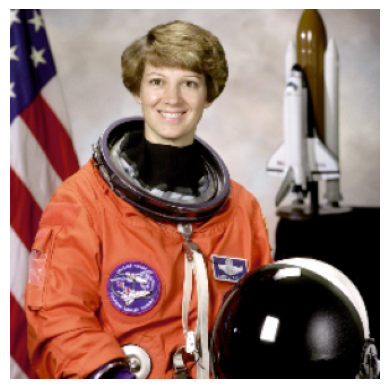

In [69]:
from skimage.data import astronaut
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

img = img_as_float(astronaut()[::2, ::2])
img = resize(img, (299, 299))
img = np.array([img])

plt.imshow(img[0])
plt.axis('off')
plt.show()

Of course, you can try your own pictures as follows:

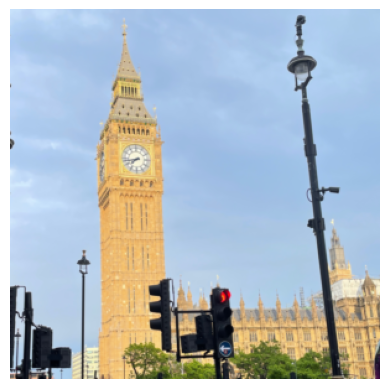

In [70]:
import skimage
image = skimage.io.imread('data/bigBen.jpeg')
image = img_as_float(image)
image = resize(image, (299, 299))
image = np.array([image])

plt.axis('off')
plt.imshow(image[0])
plt.show()

# or marcotcr (LIME's author) 's methods (It may be adjusted according to the version of tensorflow):

# from keras.preprocessing import image
#
# def transform_img_fn(path_list):
#     out = []
#     for img_path in path_list:
#         img = image.load_img(img_path, target_size=(299, 299))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = inc_net.preprocess_input(x)
#         out.append(x)
#     return np.vstack(out)
#
# images = transform_img_fn(['data/times.jpeg'])
#
# plt.axis('off')
# plt.imshow(images[0]/2+0.5)
# plt.show()

### 2. Get the predict

In [71]:
from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions

inet_model = inc_net.InceptionV3()

preds = inet_model.predict(img)
for x in decode_predictions(preds)[0]:
    print(x)


('n03379051', 'football_helmet', 0.5395003)
('n03127747', 'crash_helmet', 0.08094214)
('n02790996', 'barbell', 0.0383344)
('n02860847', 'bobsled', 0.030651012)
('n04192698', 'shield', 0.029816164)


We now have gotten 5 explainations.  The first two are both understood for there is a helmet in the picture indeed.  But we cannot find the relationship with the third predict and picture.  LIME is prepared for this.

### 3.LIME
### 3.1 Super piexl
Before applying lime, let me talk about some basic introduce about super pixel. Super pixel is appled in LIME for it can explain which part of the picture support which predict intuitively. LIME mainly uses segmentation and mark_boundaries to obtain super pixels.<br>
See the examples below:
(The following example are modified from skimage documentation. For details, such as difference with (felzenszwalb, slic, quickshift, watershed), visit https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py)

Felzenszwalb number of segments: 257
SLIC number of segments: 153
Quickshift number of segments: 56


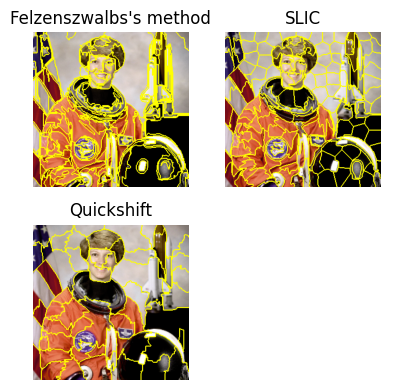

In [72]:
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries

segments_fz = felzenszwalb(img[0], scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img[0], n_segments=200, compactness=10, sigma=1,start_label=1)
segments_quick = quickshift(img[0], kernel_size=4, max_dist=200, ratio=0.2)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0, 0].imshow(mark_boundaries(img[0], segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img[0], segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img[0], segments_quick))
ax[1, 0].set_title('Quickshift')

for a in ax.ravel():
    a.set_axis_off()


plt.tight_layout()
plt.show()

### 3.2 Apply LIME
The default number of sample is 1000, so it may cost some time.
The parameters in explain_instance (modified from official documentation):

Two necessary parameters:
* image – 3 dimension RGB image. If this is only two dimensional, we will assume it's a grayscale image and call gray2rgb.
* classifier_fn – classifier prediction probability function, which takes a numpy array and outputs prediction probabilities. For ScikitClassifiers , this is classifier.predict_proba.

Common optional parameters:
* top_labels – if not None, ignore labels and produce explanations for the K labels with highest prediction probabilities, where K is this parameter.
* num_features – maximum number of features present in explanation
* num_samples – size of the neighborhood to learn the linear model
* segmentation_fn – SegmentationAlgorithm, wrapped skimage (explained as above, default is quickshift, the other two are slic and felzenszwalb)



In [73]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
x = img[0].astype(np.double)
explanation = explainer.explain_instance(x, inet_model.predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Get the explaination for barbell. The circled part may mislead classification.

The following picture expains the predict for barbell.


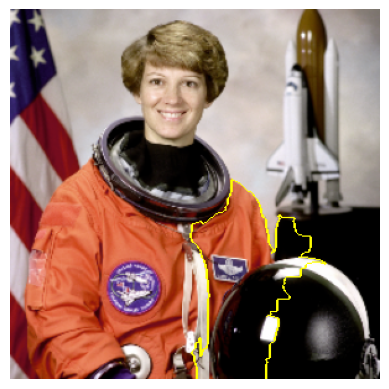

In [74]:
from skimage.segmentation import mark_boundaries

index = 2

print(f'The following picture expains the predict for {decode_predictions(preds)[0][index][1]}.')
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index])

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

### 3.3 Play around LIME
3.3.1 Select the number of features:


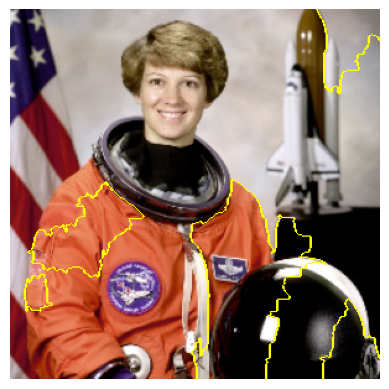

In [75]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index], num_features=10)

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

3.3.2 Hide the rest.

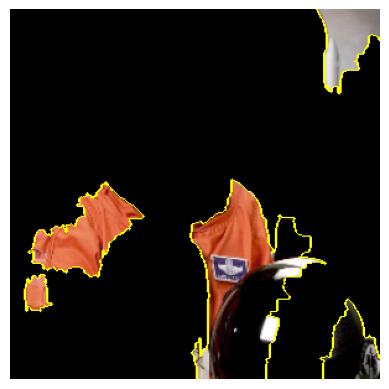

In [76]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index], num_features=10,hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


3.3.3 show the pros and cons for the selected predict. (green for pros and red for cons)

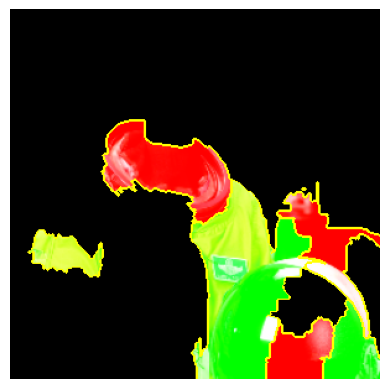

In [77]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index],num_features=10,hide_rest=True, positive_only=False)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


3.3.4 Only shows the super pixel with weight larger than 0.02

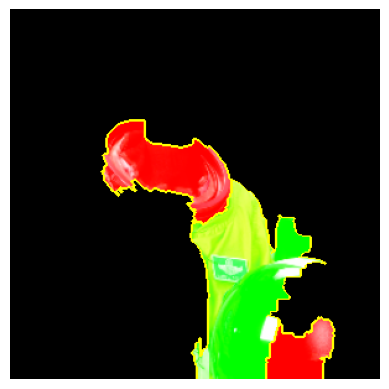

In [78]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index],num_features=10,hide_rest=True, positive_only=False,min_weight=0.02)
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

### 3.4 Drawbacks of LIME
num_samples represents size of the neighborhood to learn the linear model.
As the demonstration above, if we set the number of samples as 1000, it has cost too much !!!
And see what will happen if we set the number of samples as 50.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

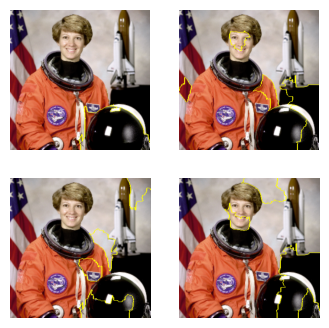

In [79]:
explanation1 = explainer.explain_instance(x, inet_model.predict,num_samples=50)
explanation2 = explainer.explain_instance(x, inet_model.predict,num_samples=50)
explanation3 = explainer.explain_instance(x, inet_model.predict,num_samples=50)
explanation4 = explainer.explain_instance(x, inet_model.predict,num_samples=50)

temp1, mask1 = explanation1.get_image_and_mask(explanation1.top_labels[0])
temp2, mask2 = explanation2.get_image_and_mask(explanation2.top_labels[0])
temp3, mask3 = explanation3.get_image_and_mask(explanation3.top_labels[0])
temp4, mask4 = explanation4.get_image_and_mask(explanation4.top_labels[0])

fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0,0].imshow(mark_boundaries(temp1, mask1))
ax[0,1].imshow(mark_boundaries(temp2, mask2))
ax[1,0].imshow(mark_boundaries(temp3, mask3))
ax[1,1].imshow(mark_boundaries(temp4, mask4))

for a in ax.ravel():
    a.set_axis_off()

plt.show()

It is easy to see that when the sample is too small, the explanation will be uncertain. Meanwhile,
when sample is too big it may cost too much time. This can be considered as a drawback of LIME.
BayLime is thus originated.
